#  Stacking Ensemble Machine Learning Model

This is a beginner's introduction to Ensembling Machine learning models using the technique of *Stacking*.

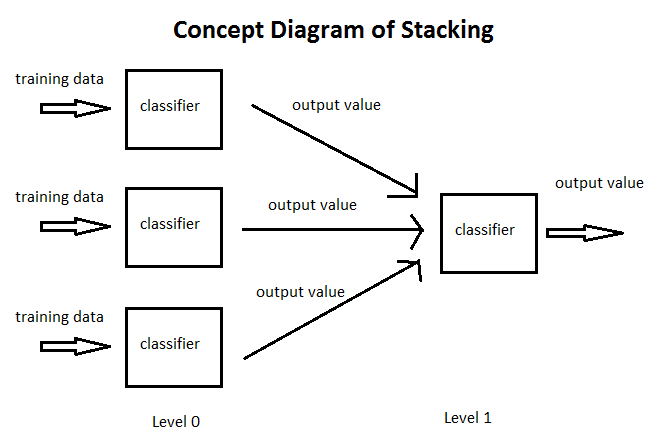

Stacking is a way to ensemble multiple classifications or regression model. There are many ways to ensemble models, the widely known techniques are Bagging or Boosting. Bagging allows multiple similar models with high variance which are averaged to decrease variance. Boosting builds multiple incremental models to decrease the bias, while keeping variance small.

Stacking is a different paradigm. The point of stacking is to explore a space of different models for the same problem. The idea is that you can attack a learning problem with different types of models which are capable to learn some part of the problem, but not the whole space of the problem. So, you can build multiple different learners and you use them to build an intermediate prediction, one prediction for each learned model. Then you add a new model which learns from the intermediate predictions for the same target.

This final model is said to be stacked on the top of the others, hence the name. Thus, you might improve your overall performance, and often you end up with a model which is better than any individual intermediate model.

# Stacking used for the Titanic competition

**Data Preprocessing**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('../input/titanic/train.csv')
df= df.drop(['Name', 'PassengerId', 'Ticket','Embarked','Cabin'], axis=1)
df['Age'] = df['Age'].fillna(df['Age'].median())

encoded= pd.get_dummies(df[['Sex']], drop_first=True)
df = pd.concat([df, encoded], axis=1)
df= df.drop(['Sex'], axis=1)


y_train = df['Survived']
X_train = df.drop('Survived', axis=1)

df1 = pd.read_csv('../input/titanic/test.csv')
df1= df1.drop(['Name', 'PassengerId', 'Ticket','Embarked','Cabin'], axis=1)
df1['Age'] = df1['Age'].fillna(df['Age'].median())
df1['Fare'] = df1['Fare'].fillna(df['Fare'].median())

encoded1 = pd.get_dummies(df1[['Sex']], drop_first=True)
df1 = pd.concat([df1, encoded1], axis=1)
df1 = df1.drop(['Sex'], axis=1)

X_test = df1

We now have an X_train,y_train and an X_test.

# Building the Stacked Ensemble

The train data will now be split into two parts, which we will call training and validation.
The initial learners(model1,model2,model3) will be trained on the training data and tested on the validation data. The final learner(meta_model) will be trained on the predictions of the initial learners on the validation data and the corresponding target variable values.

In [ ]:
#splitting train data in 2 parts

from sklearn.model_selection import train_test_split
xtraining,xvalid,ytraining,yvalid = train_test_split(X_train,y_train,test_size=0.5)

The initial learners will now be specified and trained on the training data.

In [ ]:
#importing the packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

#specifying the initial learners
model1 = RandomForestClassifier()
model2 = LogisticRegression()
model3 = xgb.XGBClassifier()

#training the initial learners
model1.fit(xtraining,ytraining)
model2.fit(xtraining,ytraining)
model3.fit(xtraining,ytraining)


The initial learners will now be used to make predictions on the validation data (which will be stacked together to form the training data for the final model) and to make predictions on the test data (which will be stacked together to form the test data for the final model).

In [ ]:
#making predictions for the validation data
preds1 = model1.predict(xvalid)
preds2 = model2.predict(xvalid)
preds3 = model3.predict(xvalid)

#making predictions for the test data
test_preds1 = model1.predict(X_test)
test_preds2 = model2.predict(X_test)
test_preds3 = model3.predict(X_test)


1. The predictions on the validation data will be stacked together to create the train set for the final model.
2. The predictions on the test data will be stacked together to create the test set for the final model. 

In [ ]:
#making a new dataset for training our final model by stacking the predictions on the validation data
train_stack = np.column_stack((preds1,preds2,preds3))

#making the final test set for our final model by stacking the predictions on the test data
test_stack = np.column_stack((test_preds1,test_preds2,test_preds3))

The final model (meta model) will be created and trained on the predictions of the models on the validation data. We will choose a random forrest classifier for this task.

In [ ]:
final_model = RandomForestClassifier()

#training the final model on the stacked predictions
final_model.fit(train_stack,yvalid)

This final model is now ready to be used to make predictions on the test data for the final results.

In [ ]:
final_predictions = final_model.predict(test_stack)